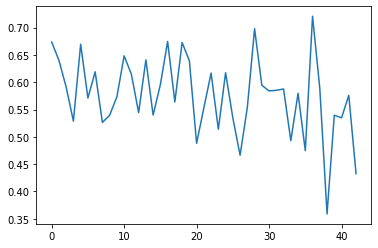

In [1]:
from matplotlib import pyplot as plt 
losses = [0.6736, 0.6403, 0.5911, 0.5287, 0.6697, 0.5710, 0.6191, 0.5263, 0.5395, 0.5732, 0.6483, 0.6146, 0.5443, 0.6410, 0.5398, 0.5957, 0.6746, 0.5639, 0.6728, 0.6394, 0.4880, 0.5530, 0.6168, 0.5138, 0.6174, 0.5346, 0.4663, 0.5538, 0.6980, 0.5945, 0.5840, 0.5852, 0.5876, 0.4929, 0.5796, 0.4745, 0.7209, 0.5886, 0.3587, 0.5395, 0.5348, 0.5759, 0.4324]

plt.plot(losses)


In [2]:
import argparse
import os
import sys
import random
import math
import shutil
import torch
import torch.nn.parallel
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import numpy as np
from tensorboardX import SummaryWriter # https://github.com/lanpa/tensorboard-pytorch
from dataset import PointcloudPatchDataset, RandomPointcloudPatchSampler, SequentialPointcloudPatchSampler, SequentialShapeRandomPointcloudPatchSampler
from networks.PCPNet import PCPNet

In [3]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
print(device)

cuda:0


In [4]:
# colored console output
green = lambda x: '\033[92m' + x + '\033[0m'
blue = lambda x: '\033[94m' + x + '\033[0m'

In [5]:
output_dir = os.path.join(os.getcwd(), 'models')
model_name = 'my_single_scale_normal'
params_filename = os.path.join(output_dir, f'{model_name}_params.pth')
model_filename = os.path.join(output_dir, f'{model_name}_model.pth')
desc_filename = os.path.join(output_dir, f'{model_name}_description.txt')
outputs = ['oriented_normals', 'max_curvature', 'min_curvature']

In [6]:
# get indices in targets and predictions corresponding to each output
target_features = []
output_target_ind = []
output_pred_ind = []
output_loss_weight = []
pred_dim = 0

# pred normal
if 'normal' not in target_features:
    target_features.append('normal')
output_target_ind.append(target_features.index('normal'))
output_pred_ind.append(pred_dim)
output_loss_weight.append(1.0)
pred_dim += 3

# pred max curvature 
if "max_curvature" not in target_features:
    target_features.append("max_curvature")
output_target_ind.append(target_features.index("max_curvature"))
output_pred_ind.append(pred_dim)
output_loss_weight.append(0.7)
pred_dim += 1

# pred min curvature 
if "min_curvature" not in target_features:
    target_features.append("min_curvature")
output_target_ind.append(target_features.index("min_curvature"))
output_pred_ind.append(pred_dim)
output_loss_weight.append(0.3)
pred_dim += 1

In [7]:
points_per_patch = 500
use_point_stn = True
use_feat_stn = True
sym_op = "max" 
point_tuple = 1
# create model
pcpnet = PCPNet(
    num_points=points_per_patch,
    output_dim=pred_dim,
    point_tuple=point_tuple)

In [16]:
old_model_path = 'models\my_single_scale_normal_model_5.pth' 
if old_model_path != '':
    pcpnet.load_state_dict(torch.load(old_model_path))

seed = random.randint(1, 10000)

random.seed(seed)
torch.manual_seed(seed)

In [17]:
input_folder_path = os.path.join(os.getcwd(), "pclouds")
trainingset_file = 'trainingset_whitenoise.txt'
testset_file = 'validationset_whitenoise.txt'
patch_radius = [0.05]
patch_point_count_std = 0
use_pca = False
identical_epochs = False
patch_center = 'point'
cache_capacity = 100
training_order = 'random'
patches_per_shape = 1000
batch_size = 64
workers = 1
# create train and test dataset loaders
train_dataset = PointcloudPatchDataset(
    root=input_folder_path,
    shape_list_filename=trainingset_file,
    patch_radius=patch_radius,
    points_per_patch=points_per_patch,
    patch_features=target_features,
    point_count_std=patch_point_count_std,
    seed=seed,
    identical_epochs=identical_epochs,
    use_pca=use_pca,
    center=patch_center,
    point_tuple=point_tuple,
    cache_capacity=cache_capacity)

if training_order == 'random':
    train_datasampler = RandomPointcloudPatchSampler(
        train_dataset,
        patches_per_shape=patches_per_shape,
        seed=seed,
        identical_epochs=identical_epochs)
elif training_order == 'random_shape_consecutive':
    train_datasampler = SequentialShapeRandomPointcloudPatchSampler(
        train_dataset,
        patches_per_shape=patches_per_shape,
        seed=seed,
        identical_epochs=identical_epochs)
    
train_dataloader = torch.utils.data.DataLoader(
train_dataset,
sampler=train_datasampler,
batch_size=batch_size,
num_workers=int(workers))

getting information for shape fandisk100k
getting information for shape bunny100k
getting information for shape armadillo100k
getting information for shape dragon_xyzrgb100k
getting information for shape boxunion_uniform100k
getting information for shape tortuga100k
getting information for shape flower100k
getting information for shape Cup33100k
getting information for shape fandisk100k_noise_white_1.00e-02
getting information for shape bunny100k_noise_white_1.00e-02
getting information for shape armadillo100k_noise_white_1.00e-02
getting information for shape dragon_xyzrgb100k_noise_white_1.00e-02
getting information for shape boxunion_uniform100k_noise_white_1.00e-02
getting information for shape tortuga100k_noise_white_1.00e-02
getting information for shape flower100k_noise_white_1.00e-02
getting information for shape Cup33100k_noise_white_1.00e-02
getting information for shape fandisk100k_noise_white_5.00e-02
getting information for shape bunny100k_noise_white_5.00e-02
getting info

In [18]:
test_dataset = PointcloudPatchDataset(
    root=input_folder_path,
    shape_list_filename=testset_file,
    patch_radius=patch_radius,
    points_per_patch=points_per_patch,
    patch_features=target_features,
    point_count_std=patch_point_count_std,
    seed=seed,
    identical_epochs=identical_epochs,
    use_pca=use_pca,
    center=patch_center,
    point_tuple=point_tuple,
    cache_capacity=cache_capacity)
if training_order == 'random':
    test_datasampler = RandomPointcloudPatchSampler(
        test_dataset,
        patches_per_shape=patches_per_shape,
        seed=seed,
        identical_epochs=identical_epochs)
elif training_order == 'random_shape_consecutive':
    test_datasampler = SequentialShapeRandomPointcloudPatchSampler(
        test_dataset,
        patches_per_shape=patches_per_shape,
        seed=seed,
        identical_epochs=identical_epochs)
else:
    raise ValueError('Unknown training order: %s' % (opt.training_order))

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    sampler=test_datasampler,
    batch_size=batch_size,
    num_workers=int(workers))

getting information for shape cylinder100k
getting information for shape galera100k
getting information for shape netsuke100k
getting information for shape cylinder100k_noise_white_1.00e-02
getting information for shape galera100k_noise_white_1.00e-02
getting information for shape netsuke100k_noise_white_1.00e-02
getting information for shape cylinder100k_noise_white_5.00e-02
getting information for shape galera100k_noise_white_5.00e-02
getting information for shape netsuke100k_noise_white_5.00e-02
getting information for shape cylinder100k_noise_white_1.00e-01
getting information for shape galera100k_noise_white_1.00e-01
getting information for shape netsuke100k_noise_white_1.00e-01


In [19]:
lr = 0.0001
momentum = 0.9
optimizer = optim.SGD(pcpnet.parameters(), lr=lr, momentum=momentum)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1) # milestones in number of optimizer iterations
pcpnet.to(device)

train_num_batch = len(train_dataloader)
test_num_batch = len(test_dataloader)

In [40]:
def cos_angle(v1, v2):
    return torch.bmm(v1.unsqueeze(1), v2.unsqueeze(2)).view(-1) / torch.clamp(v1.norm(2, 1) * v2.norm(2, 1), min=0.000001)


def compute_loss(pred, target, outputs, output_pred_ind, output_target_ind, output_loss_weight, patch_rot):
    loss = 0

    for oi, o in enumerate(outputs):
        if o == 'unoriented_normals' or o == 'oriented_normals':
            o_pred = pred[:, output_pred_ind[oi]:output_pred_ind[oi]+3]
            o_target = target[output_target_ind[oi]]

            if patch_rot is not None:
                # transform predictions with inverse transform
                # since we know the transform to be a rotation (QSTN), the transpose is the inverse
                o_pred = torch.bmm(o_pred.unsqueeze(1), patch_rot.transpose(2, 1)).squeeze(1)

            if o == 'unoriented_normals':
                loss += torch.min((o_pred-o_target).pow(2).sum(1), (o_pred+o_target).pow(2).sum(1)).mean() * output_loss_weight[oi]
            elif o == 'oriented_normals':
                loss += (o_pred-o_target).pow(2).sum(1).mean() * output_loss_weight[oi]
                
        elif o == 'max_curvature' or o == 'min_curvature':
            o_pred = pred[:, output_pred_ind[oi]:output_pred_ind[oi]+1]
            o_target = target[output_target_ind[oi]]

            # Rectified mse loss: mean square of (pred - gt) / max(1, |gt|)
            normalized_diff = (o_pred - o_target) / torch.clamp(torch.abs(o_target), min=1)
            loss += normalized_diff.pow(2).mean() * output_loss_weight[oi]

    return loss


In [41]:
nepoch = 2000
save_interval = 10

for epoch in range(nepoch):
    train_batchind, test_batchind = -1, -1
    train_fraction_done, test_fraction_done = 0.0, 0.0
    train_enum, test_enum = enumerate(train_dataloader, 0), enumerate(test_dataloader, 0)

    for train_batchind, data in train_enum:

        # update learning rate
        scheduler.step(epoch * train_num_batch + train_batchind)

        # set to training mode
        pcpnet.train()

        # get trainingset batch and upload to GPU
        points = data[0]
        target = data[1:-1]

        points = points.transpose(2, 1)
        points = points.to(device)

        target = tuple(t.to(device) for t in target)

        # zero gradients
        optimizer.zero_grad()

        # forward pass
        pred, trans, _, _ = pcpnet(points)

        loss = compute_loss(
            pred=pred, target=target,
            outputs=outputs,
            output_pred_ind=output_pred_ind,
            output_target_ind=output_target_ind,
            output_loss_weight=output_loss_weight,
            patch_rot=trans)

        # backpropagate through entire network to compute gradients of loss w.r.t. parameters
        loss.backward()

        # parameter optimization step
        optimizer.step()

        train_fraction_done = (train_batchind+1) / train_num_batch

        # print info and update log file
        print('[%s %d: %d/%d] %s loss: %f' % (model_name, epoch, train_batchind, train_num_batch-1, green('train'), loss.item()))

        while test_fraction_done <= train_fraction_done and test_batchind+1 < test_num_batch:

            # set to evaluation mode
            pcpnet.eval()

            test_batchind, data = next(test_enum)

            # get testset batch and upload to GPU
            points = data[0]
            target = data[1:-1]

            points = points.transpose(2, 1)
            points = points.to(device)

            target = tuple(t.to(device) for t in target)

            # forward pass
            with torch.no_grad():
                pred, trans, _, _ = pcpnet(points)

            loss = compute_loss(
                pred=pred, target=target,
                outputs=outputs,
                output_pred_ind=output_pred_ind,
                output_target_ind=output_target_ind,
                output_loss_weight=output_loss_weight,
                patch_rot=trans)

            test_fraction_done = (test_batchind+1) / test_num_batch

            # print info and update log file
            print('[%s %d: %d/%d] %s loss: %f' % (model_name, epoch, train_batchind, train_num_batch-1, blue('test'), loss.item()))

    # save model, overwriting the old model
    if epoch % save_interval == 0 or epoch == nepoch-1:
        torch.save(pcpnet.state_dict(), model_filename)

    # save model in a separate file in epochs 0,5,10,50,100,500,1000, ...
    if epoch % (5 * 10**math.floor(math.log10(max(2, epoch-1)))) == 0 or epoch % 100 == 0 or epoch == nepoch-1:
        torch.save(pcpnet.state_dict(), os.path.join(output_dir, '%s_model_%d.pth' % (model_name, epoch)))



[my_single_scale_normal 0: 0/499] train loss: 1.147645
[my_single_scale_normal 0: 0/499] test loss: 1.091515
[my_single_scale_normal 0: 1/499] train loss: 1.223634
[my_single_scale_normal 0: 2/499] train loss: 1.331071
[my_single_scale_normal 0: 2/499] test loss: 1.192050
[my_single_scale_normal 0: 3/499] train loss: 0.991590
[my_single_scale_normal 0: 4/499] train loss: 1.160223
[my_single_scale_normal 0: 5/499] train loss: 1.129225
[my_single_scale_normal 0: 5/499] test loss: 1.347744
[my_single_scale_normal 0: 6/499] train loss: 1.055507
[my_single_scale_normal 0: 7/499] train loss: 1.004614
[my_single_scale_normal 0: 7/499] test loss: 1.119549
[my_single_scale_normal 0: 8/499] train loss: 1.118449
[my_single_scale_normal 0: 9/499] train loss: 1.070136
[my_single_scale_normal 0: 10/499] train loss: 1.171391
[my_single_scale_normal 0: 10/499] test loss: 1.204103
[my_single_scale_normal 0: 11/499] train loss: 1.076431
[my_single_scale_normal 0: 12/499] train loss: 1.267035
[my_single_

KeyboardInterrupt: 

In [42]:
dataset_file_path = 'testset_no_noise.txt'
sampling = 'full'
sparse_patches = False
dataset = PointcloudPatchDataset(
            root=input_folder_path, shape_list_filename=dataset_file_path,
            patch_radius=patch_radius,
            points_per_patch=points_per_patch,
            patch_features=[],
            seed=seed,
            use_pca=use_pca,
            center=patch_center,
            point_tuple=point_tuple,
            sparse_patches=sparse_patches,
            cache_capacity=cache_capacity)
if sampling == 'full':
    datasampler = SequentialPointcloudPatchSampler(dataset)
elif sampling == 'sequential_shapes_random_patches':
    datasampler = SequentialShapeRandomPointcloudPatchSampler(
        dataset,
        patches_per_shape=patches_per_shape,
        seed=seed,
        sequential_shapes=True,
        identical_epochs=False)
else:
    raise ValueError('Unknown sampling strategy: %s' % sampling)
dataloader = torch.utils.data.DataLoader(
    dataset,
    sampler=datasampler,
    batch_size=batch_size,
    num_workers=int(workers))

getting information for shape galera100k
getting information for shape icosahedron100k
getting information for shape netsuke100k
getting information for shape Cup34100k
getting information for shape sphere100k
getting information for shape cylinder100k
getting information for shape star_smooth100k
getting information for shape star_halfsmooth100k
getting information for shape star_sharp100k
getting information for shape Liberty100k
getting information for shape boxunion2100k
getting information for shape pipe100k
getting information for shape pipe_curve100k
getting information for shape column100k
getting information for shape column_head100k
getting information for shape Boxy_smooth100k
getting information for shape sphere_analytic100k
getting information for shape cylinder_analytic100k
getting information for shape sheet_analytic100k


In [43]:
shape_ind = 0
shape_patch_offset = 0
if sampling == 'full':
    shape_patch_count = dataset.shape_patch_count[shape_ind]
elif sampling == 'sequential_shapes_random_patches':
    shape_patch_count = min(patches_per_shape, dataset.shape_patch_count[shape_ind])
shape_properties = torch.zeros(shape_patch_count, pred_dim, dtype=torch.float, device=device)

In [48]:
num_batch = len(dataloader)
batch_enum = enumerate(dataloader, 0)  
model_outdir = os.path.join(output_dir, model_name)

for batchind, data in tqdm(batch_enum):
    if batchind == 20:
        break
    # get batch and upload to GPU
    points, data_trans = data
    points = points.transpose(2, 1)
    points = points.to(device)

    data_trans = data_trans.to(device)

    with torch.no_grad():
        pred, trans, _, _ = pcpnet(points)

    # post-processing of the prediction
    for oi, o in enumerate(outputs):
        if o == 'unoriented_normals' or o == 'oriented_normals':
            o_pred = pred[:, output_pred_ind[oi]:output_pred_ind[oi]+3]

            # transform predictions with inverse transform
            # since we know the transform to be a rotation (QSTN), the transpose is the inverse
            o_pred[:, :] = torch.bmm(o_pred.unsqueeze(1), trans.transpose(2, 1)).squeeze(dim=1)

            # normalize normals
            o_pred_len = torch.max(o_pred.new_tensor([sys.float_info.epsilon*100]), o_pred.norm(p=2, dim=1, keepdim=True))
            o_pred = o_pred / o_pred_len

        elif o == 'max_curvature' or o == 'min_curvature':
            o_pred = pred[:, output_pred_ind[oi]:output_pred_ind[oi]+1]

            # undo patch size normalization:
            o_pred[:, :] = o_pred / dataset.patch_radius_absolute[shape_ind][0]


    #print('[%s %d/%d] shape %s' % (model_name, batchind, num_batch-1, dataset.shape_names[shape_ind]))

    batch_offset = 0
    while batch_offset < pred.size(0):

        shape_patches_remaining = shape_patch_count-shape_patch_offset
        batch_patches_remaining = pred.size(0)-batch_offset

        # append estimated patch properties batch to properties for the current shape
        shape_properties[shape_patch_offset:shape_patch_offset+min(shape_patches_remaining, batch_patches_remaining), :] = pred[
            batch_offset:batch_offset+min(shape_patches_remaining, batch_patches_remaining), :]

        batch_offset = batch_offset + min(shape_patches_remaining, batch_patches_remaining)
        shape_patch_offset = shape_patch_offset + min(shape_patches_remaining, batch_patches_remaining)

        if shape_patches_remaining <= batch_patches_remaining:
            print(1)

            # save shape properties to disk
            prop_saved = [False]*len(outputs)

            # save normals
            oi = [i for i, o in enumerate(outputs) if o in ['unoriented_normals', 'oriented_normals']]
            if len(oi) > 1:
                raise ValueError('Duplicate normal output.')
            elif len(oi) == 1:
                oi = oi[0]
                normal_prop = shape_properties[:, output_pred_ind[oi]:output_pred_ind[oi]+3]
                np.savetxt(os.path.join(model_outdir, dataset.shape_names[shape_ind]+'.normals'), normal_prop.cpu().numpy())
                print(os.path.join(model_outdir, dataset.shape_names[shape_ind]+'.normals'))
                prop_saved[oi] = True

            # save curvatures
            oi1 = [i for i, o in enumerate(outputs) if o == 'max_curvature']
            oi2 = [i for i, o in enumerate(outputs) if o == 'min_curvature']
            if len(oi1) > 1 or len(oi2) > 1:
                raise ValueError('Duplicate minimum or maximum curvature output.')
            elif len(oi1) == 1 or len(oi2) == 1:
                curv_prop = shape_properties.new_zeros(shape_properties.size(0), 2)
                if len(oi1) == 1:
                    oi1 = oi1[0]
                    curv_prop[:, 0] = shape_properties[:, output_pred_ind[oi1]]
                    prop_saved[oi1] = True
                if len(oi2) == 1:
                    oi2 = oi2[0]
                    curv_prop[:, 1] = shape_properties[:, output_pred_ind[oi2]]
                    prop_saved[oi2] = True
                np.savetxt(os.path.join(model_outdir, dataset.shape_names[shape_ind]+'.curv'), curv_prop.cpu().numpy())

            if not all(prop_saved):
                raise ValueError('Not all shape properties were saved, some of them seem to be unsupported.')

            # save point indices
            if sampling != 'full':
                np.savetxt(os.path.join(model_outdir, dataset.shape_names[shape_ind]+'.idx'), datasampler.shape_patch_inds[shape_ind], fmt='%d')

            # start new shape
            if shape_ind + 1 < len(dataset.shape_names):
                shape_patch_offset = 0
                shape_ind = shape_ind + 1
                if sampling == 'full':
                    shape_patch_count = dataset.shape_patch_count[shape_ind]
                elif sampling == 'sequential_shapes_random_patches':
                    # shape_patch_count = min(opt.patches_per_shape, dataset.shape_patch_count[shape_ind])
                    shape_patch_count = len(datasampler.shape_patch_inds[shape_ind])
                else:
                    raise ValueError('Unknown sampling strategy: %s' % sampling)
                shape_properties = shape_properties.new_zeros(shape_patch_count, pred_dim)


[my_single_scale_normal 0/29687] shape galera100k
[my_single_scale_normal 1/29687] shape galera100k
[my_single_scale_normal 2/29687] shape galera100k
[my_single_scale_normal 3/29687] shape galera100k
[my_single_scale_normal 4/29687] shape galera100k
[my_single_scale_normal 5/29687] shape galera100k
[my_single_scale_normal 6/29687] shape galera100k
[my_single_scale_normal 7/29687] shape galera100k
[my_single_scale_normal 8/29687] shape galera100k
[my_single_scale_normal 9/29687] shape galera100k
[my_single_scale_normal 10/29687] shape galera100k
[my_single_scale_normal 11/29687] shape galera100k
[my_single_scale_normal 12/29687] shape galera100k
[my_single_scale_normal 13/29687] shape galera100k
[my_single_scale_normal 14/29687] shape galera100k
[my_single_scale_normal 15/29687] shape galera100k
[my_single_scale_normal 16/29687] shape galera100k
[my_single_scale_normal 17/29687] shape galera100k
[my_single_scale_normal 18/29687] shape galera100k
[my_single_scale_normal 19/29687] shape g

100%|██████████| 1000/1000 [00:03<00:00, 332.39it/s]


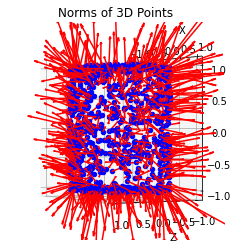

In [135]:
from tqdm import tqdm
# Read coordinates from file
folder = 'results'
name_shape = 'cylinder100k'
coordinates_file_path = f'pclouds\\{name_shape}.xyz'
coordinates = np.loadtxt(coordinates_file_path)

# Read norms from file
norms_file_path = f'{folder}\\{name_shape}.normals'
norms = np.loadtxt(norms_file_path)


# Plotting the norms in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

limits = 1000
# Scatter plot for each point with the corresponding norms
for i in tqdm(range(limits)):
    ax.scatter(coordinates[i, 0], coordinates[i, 1], coordinates[i, 2], c='b', marker='o')
    ax.quiver(coordinates[i, 0], coordinates[i, 1], coordinates[i, 2],
              norms[i, 0], norms[i, 1], norms[i, 2], color='r', length=1, arrow_length_ratio=0.1)

# Adding labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Norms of 3D Points')

ax.view_init(elev=30, azim=0, roll=90)

# Display the plot
plt.show()

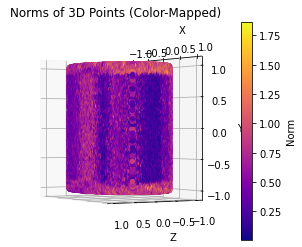

In [136]:

# Calculate the scalar norms (magnitude)
scalar_norms = np.linalg.norm(norms, axis=1)

# Plotting the norms in 3D with colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

limits = 50000
# Scatter plot with color mapping based on norms
scatter = ax.scatter(coordinates[:limits, 0], coordinates[:limits, 1], coordinates[:limits, 2], c=scalar_norms[:limits], cmap='plasma', marker='o')

# Adding labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Norms of 3D Points (Color-Mapped)')

# Adding colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Norm')

ax.view_init(elev=30, azim=0, roll=90)

# Display the plot
plt.show()

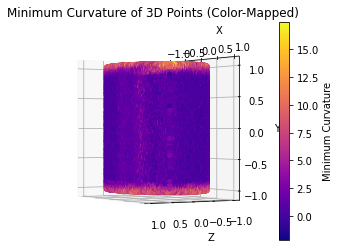

In [137]:
curvature_file_path = f'{folder}\{name_shape}.curv'
min_curvature, max_curvature = np.loadtxt(curvature_file_path, unpack=True)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapping based on minimum curvature
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=min_curvature, cmap='plasma', marker='o')

# Adding labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Minimum Curvature of 3D Points (Color-Mapped)')

# Adding colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Minimum Curvature')

ax.view_init(elev=30, azim=0, roll=90)

# Display the plot
plt.show()

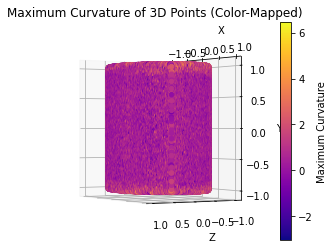

In [138]:
curvature_file_path = f'{folder}\{name_shape}.curv'
min_curvature, max_curvature = np.loadtxt(curvature_file_path, unpack=True)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapping based on minimum curvature
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=max_curvature, cmap='plasma', marker='o')

# Adding labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Maximum Curvature of 3D Points (Color-Mapped)')

# Adding colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Maximum Curvature')

ax.view_init(elev=30, azim=0, roll=90)

# Display the plot
plt.show()